# **Cortex Predicitve Analytics Fundraising Scenario**

**ROUND 2 - STAGE 2: Predict uplift**

Daniel Salvador Cázares García A01197517

# **Set up**

## **Connect to SASPy**

**0- Connect to Google Drive**

In [ ]:
my_folder = "/content/drive/MyDrive/"

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(my_folder)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Concentración IA & DS/Reto SAS


**1. Python & Java version**

In [ ]:
!echo "Python is at" $(which python)
!python --version

Python is at /usr/local/bin/python
Python 3.8.15


In [ ]:
!echo "Java is at" $(which java)
!/usr/bin/java -version

Java is at /usr/bin/java
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


**2- Install SASPy**

In [ ]:
pip install saspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.5 MB/s 
  Created wheel for saspy: filename=saspy-4.4.1-py3-none-any.whl size=9937304 sha256=91d4a8e48b45e673fda9aed61f6e7aebd9f0d4835fe88e3f17077c6d8828188a
  Stored in directory: /root/.cache/pip/wheels/0a/f6/ab/f7173c8a824856c66f6fd50194bb8fd3ef93fb4f1824be8d0c
Successfully built saspy


**3. Configuration file**

In [ ]:
%%writefile sascfg_personal.py
SAS_config_names=['oda']
oda = {'java' : '/usr/bin/java',
#US Home Region 2
'iomhost' : ['odaws01-usw2-2.oda.sas.com','odaws02-usw2-2.oda.sas.com'],
'iomport' : 8591,
'authkey' : 'oda',
'encoding' : 'utf-8'
}

Overwriting sascfg_personal.py


**4- Create your .authinfo**

In [ ]:
%%writefile .authinfo
oda user your-user@mail.com password your.password

Overwriting .authinfo


In [ ]:
!cp .authinfo ~/.authinfo

**5- Establish Connection**

In [ ]:
import saspy
sas_session = saspy.SASsession(cfgfile="/content/drive/MyDrive/sascfg_personal.py")
sas_session

Using SAS Config named: oda
SAS Connection established. Subprocess id is 386



Access Method         = IOM
SAS Config name       = oda
SAS Config file       = /content/drive/MyDrive/Concentración IA & DS/Reto SAS/sascfg_personal.py
WORK Path             = /saswork/SAS_work71150001AE60_odaws02-usw2-2.oda.sas.com/SAS_work4CC00001AE60_odaws02-usw2-2.oda.sas.com/
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 4.4.1
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = utf-8
Python Encoding value = utf-8
SAS process Pid value = 110176


## Connect to Cortex Data Sets

In [ ]:
ps = sas_session.submit("""
    libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';
    """)
print(ps["LOG"])


5                                                          The SAS System                      Friday, December  2, 2022 06:58:00 AM

24         ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
24       ! ods graphics on / outputfmt=png;
25         
26         
27             libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';
28         
29         
30         
31         ods html5 (id=saspy_internal) close;ods listing;
32         

6                                                          The SAS System                      Friday, December  2, 2022 06:58:00 AM

33         


### Transform SAS dataset to dataframe

In [ ]:
import pandas as pd

data1 = sas_session.sasdata2dataframe(
table='hist',
libref='cortex'
)

data2 = sas_session.sasdata2dataframe(
table='target_rd2',
libref='cortex'
)

In [ ]:
data_merge = pd.merge(data1, data2, on=["ID"],how="right")
data_merge.sample(2)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
54504,2054505.0,ROJAS,SUSAN,1.0,29.0,33800.0,Elementary,Rural,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
168123,2168124.0,URBATSCH,SHANNA,1.0,35.0,59100.0,University / College,Rural,2.0,1.0,...,1.0,1.0,30.0,30.0,30.0,1.0,15.0,0.0,0.0,0.0


# **Model**

## Data Prep

Missing Values

In [ ]:
target_data = data_merge

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(target_data[['Education', 'City']])
ohe_df = pd.DataFrame(data=ohe.transform(target_data[['Education', 'City']]), columns=ohe.get_feature_names_out())

target_data = target_data.join(ohe_df)

In [ ]:
target_data['Recency'] = target_data['Recency'].fillna((target_data['GaveLastYear'] == 1.0).map({True: 1.0}))
target_data['Recency'] = target_data['Recency'].fillna(value=0)
target_data['Frequency'] = target_data['Frequency'].fillna((target_data['GaveLastYear'] == 1.0).map({True: 1.0}))
target_data['Frequency'] = target_data['Frequency'].fillna(value=0)

In [ ]:
target_data['MinGift'] = target_data['MinGift'].fillna(target_data['AmtLastYear'])  
target_data['MaxGift'] = target_data['MaxGift'].fillna(target_data['AmtLastYear'])
target_data['TotalGift'] = target_data['TotalGift'].fillna(target_data['AmtLastYear'])

## Data Partition

In [ ]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(target_data, train_size=0.8, random_state=42) 

In [ ]:
# Seniority, Seniority, 
selected_cols = ['Woman', 'Age', 'Salary',
       'NbActivities', 'Referrals', 'Recency',
       'TotalGift', 'MinGift', 'MaxGift',
       'GaveLastYear', 'AmtLastYear', 'Contact',
       'Education_Elementary', 'Education_High School',
       'Education_University / College', 'City_City', 'City_Downtown',
       'City_Rural', 'City_Suburban']

In [ ]:
X_train = train[selected_cols] 
Y_train = train['GaveThisYear']

X_valid = validation[selected_cols] 
Y_valid = validation['GaveThisYear']

# Training

In [ ]:
import numpy as np

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(max_depth=5,criterion="entropy").fit(X_train,Y_train)
DT_predict_proba = DT_model.predict_proba(X_valid)
DT_pred = DT_model.predict(X_valid)

# Probabilities for each class
DT_probs = DT_model.predict_proba(X_valid)[:, 1]

[0.09801803 0.10484057 0.12759897 ... 0.11628881 0.09801803 0.12759897]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_valid, DT_pred)
print(confusion_matrix)

[[169938    116]
 [ 29780    166]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid, DT_pred))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92    170054
         1.0       0.59      0.01      0.01     29946

    accuracy                           0.85    200000
   macro avg       0.72      0.50      0.47    200000
weighted avg       0.81      0.85      0.78    200000



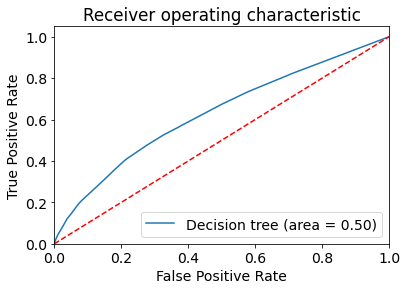

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

DT_roc_auc = roc_auc_score(Y_valid, DT_model.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, DT_model.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

# Results

## Scoring New Data

In [ ]:
data3 = sas_session.sasdata2dataframe(
table='score',
libref='cortex'
)
data4 = sas_session.sasdata2dataframe(
table='score_rd2_contact',
libref='cortex'
)
data5 = sas_session.sasdata2dataframe(
table='SCORE_RD2_NOCONTACT',
libref='cortex'
)

## Predict 'probability of giving' for members who were contacted

### Data

In [ ]:
scoring_data_contact = pd.merge(data3, data4, on=["ID"],how="right")

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(scoring_data_contact[['Education', 'City']])
ohe_df = pd.DataFrame(data=ohe.transform(scoring_data_contact[['Education', 'City']]), columns=ohe.get_feature_names_out())

scoring_data_contact = pd.concat([scoring_data_contact.reset_index(drop=True), ohe_df], axis='columns')

scoring_data_contact['Recency'] = scoring_data_contact['Recency'].fillna((scoring_data_contact['GaveLastYear'] == 1.0).map({True: 1.0}))
scoring_data_contact['Recency'] = scoring_data_contact['Recency'].fillna(value=0)
scoring_data_contact['Frequency'] = scoring_data_contact['Frequency'].fillna((scoring_data_contact['GaveLastYear'] == 1.0).map({True: 1.0}))
scoring_data_contact['Frequency'] = scoring_data_contact['Frequency'].fillna(value=0)

scoring_data_contact['MinGift'] = scoring_data_contact['MinGift'].fillna(scoring_data_contact['AmtLastYear'])  
scoring_data_contact['MaxGift'] = scoring_data_contact['MaxGift'].fillna(scoring_data_contact['AmtLastYear'])
scoring_data_contact['TotalGift'] = scoring_data_contact['TotalGift'].fillna(scoring_data_contact['AmtLastYear'])

In [ ]:
X = scoring_data_contact[selected_cols]

### Training

In [ ]:
contact_pred = DT_model.predict_proba(X)[:,1]

In [ ]:
scoring_data_contact['Prediction_prob'] = contact_pred

scoring_data_contact = scoring_data_contact[['ID','Prediction_prob']]
scoring_data_contact = scoring_data_contact.rename({'Prediction_prob': 'ProbContact'}, axis=1) 
scoring_data_contact.head()

,ID,ProbContact
0,2000001.0,0.116289
1,2000002.0,0.127599
2,2000003.0,0.127599
3,2000004.0,0.098018
4,2000005.0,0.127599


## Predict 'probability of giving' for members who were NOT contacted

### Data

In [ ]:
scoring_data_nocontact = pd.merge(data3, data5, on=["ID"],how="right")

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(scoring_data_nocontact[['Education', 'City']])
ohe_df = pd.DataFrame(data=ohe.transform(scoring_data_nocontact[['Education', 'City']]), columns=ohe.get_feature_names_out())

scoring_data_nocontact = pd.concat([scoring_data_nocontact.reset_index(drop=True), ohe_df], axis='columns')

scoring_data_nocontact['Recency'] = scoring_data_nocontact['Recency'].fillna((scoring_data_nocontact['GaveLastYear'] == 1.0).map({True: 1.0}))
scoring_data_nocontact['Recency'] = scoring_data_nocontact['Recency'].fillna(value=0)
scoring_data_nocontact['Frequency'] = scoring_data_nocontact['Frequency'].fillna((scoring_data_nocontact['GaveLastYear'] == 1.0).map({True: 1.0}))
scoring_data_nocontact['Frequency'] = scoring_data_nocontact['Frequency'].fillna(value=0)

scoring_data_nocontact['MinGift'] = scoring_data_nocontact['MinGift'].fillna(scoring_data_nocontact['AmtLastYear'])  
scoring_data_nocontact['MaxGift'] = scoring_data_nocontact['MaxGift'].fillna(scoring_data_nocontact['AmtLastYear'])
scoring_data_nocontact['TotalGift'] = scoring_data_nocontact['TotalGift'].fillna(scoring_data_nocontact['AmtLastYear'])

### Training

In [ ]:
nocontact_pred = DT_model.predict_proba(X)[:,1]

In [ ]:
scoring_data_nocontact['Prediction_prob'] = nocontact_pred

scoring_data_nocontact= scoring_data_nocontact[['ID','Prediction_prob']]
scoring_data_nocontact = scoring_data_nocontact.rename({'Prediction_prob': 'ProbNoContact'}, axis=1) 
scoring_data_nocontact.head()

,ID,ProbNoContact
0,2000001.0,0.116289
1,2000002.0,0.127599
2,2000003.0,0.127599
3,2000004.0,0.098018
4,2000005.0,0.127599


## Exporting Results to CSV

In [ ]:
result_Prob = pd.merge(scoring_data_contact, scoring_data_nocontact, on=["ID"],how="right")
result_Prob.sort_values(by=['ID'], inplace=True)
result_Prob.sample(10)

,ID,ProbContact,ProbNoContact
783027,2783028.0,0.176271,0.176271
699063,2699064.0,0.104841,0.104841
780583,2780584.0,0.154344,0.154344
164542,2164543.0,0.104841,0.104841
266935,2266936.0,0.139207,0.139207
665233,2665234.0,0.098018,0.098018
115969,2115970.0,0.127599,0.127599
831945,2831946.0,0.161963,0.161963
639718,2639719.0,0.154344,0.154344
151221,2151222.0,0.116289,0.116289


In [ ]:
result_Prob.to_csv('Round2_Output_prob.csv', index=False)

In [ ]:
import pandas as pd

probabilities = pd.read_csv("Round2_Output_prob.csv")
amounts = pd.read_csv("Round2_Output_amt.csv")

def Calc_Uplift(raw_data):
    return ((raw_data['AmtContact']*raw_data['ProbContact']) - (raw_data['AmtNoContact']*raw_data['ProbNoContact']))

raw_submission = pd.merge(probabilities, amounts, on=["ID"], how="right")
raw_submission["Uplift"] = raw_submission.apply(lambda row: Calc_Uplift(row), axis=1)

# Sorting data by descending Uplift value
raw_submission.sort_values(by=['Uplift'], ascending=False, inplace=True)

In [ ]:
raw_submission.sort_values(by=['Uplift'], ascending=False, inplace=True)

In [ ]:
NB = 100000
submission = raw_submission.head(NB)
submission.to_csv('R2 Output final.csv', index=False)

In [ ]:
!head R2\ Output\ final.csv

ID,ProbContact,ProbNoContact,AmtContact,AmtNoContact,Uplift
2000001.0,0.1162888109325095,0.1162888109325095,72.74684,72.74684,0.0
2666660.0,0.2628527251642829,0.2628527251642829,48.339684,48.339684,0.0
2666662.0,0.15434393501308,0.15434393501308,67.9788,67.9788,0.0
2666663.0,0.2085865162037037,0.2085865162037037,64.01835,64.01835,0.0
2666664.0,0.129441468070694,0.129441468070694,54.29862,54.29862,0.0
2666665.0,0.1162888109325095,0.1162888109325095,44.48464,44.48464,0.0
2666666.0,0.2628527251642829,0.2628527251642829,85.39035,85.39035,0.0
2666667.0,0.1162888109325095,0.1162888109325095,64.40786,64.40786,0.0
2666668.0,0.1400932400932401,0.1400932400932401,57.55771,57.55771,0.0
